In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [2]:
# load dataset
# split into input (X) and output (y) variables

df = pd.read_csv("../dataset/student_new.csv")

# data cleaning
df = df.drop(columns=["Timestamp"])
df = df.drop(columns=["ID"])
df = df.apply(lambda x: x.strip() if isinstance(x, str) else x).replace("", None)

class_x = df.drop(columns=["JOB_ROLE"])  # all data without job role
class_y = df["JOB_ROLE"]  # Only the job role colum

x_train, x_test, y_train, y_test = train_test_split(
    class_x,
    class_y,
    test_size=0.3,  # 30% of the data will be used for testing
    random_state=2,
)

In [3]:
# encoding
label_encoder = preprocessing.LabelEncoder()
x_train["Specialization"] = label_encoder.fit_transform(x_train["Specialization"])
x_test["Specialization"] = label_encoder.fit_transform(x_test["Specialization"])

# fill missing values
x_train = x_train.fillna(x_train.mean())
x_test = x_test.fillna(x_test.mean())



In [4]:
from sklearn.multiclass import OneVsRestClassifier

# create model
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

RandomForestClassifier()

In [5]:
# 2. GB Model Test Results

from sklearn.ensemble import GradientBoostingClassifier

gb = OneVsRestClassifier(
    GradientBoostingClassifier(
        random_state=1,
        n_estimators=100,
        max_depth=10,
    )
)
gb.fit(x_train, y_train)

OneVsRestClassifier(estimator=GradientBoostingClassifier(max_depth=10,
                                                         random_state=1))

In [6]:
# 3. Logistic Regression Model Test Results

from sklearn.linear_model import LogisticRegression

logistic = OneVsRestClassifier(
    LogisticRegression(
        random_state=1,
        max_iter=10000,
        solver="lbfgs",
    )
)
logistic.fit(x_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=10000,
                                                 random_state=1))

In [7]:
import warnings
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier

warnings.filterwarnings("ignore")

stacking = StackingClassifier(
    estimators=[
        ("rf", rf),
        ("gb", gb),
        ("logistic", logistic),
    ],
    final_estimator=MLPClassifier(
        random_state=1, max_iter=10000, hidden_layer_sizes=(100, 100), solver="adam"
    ),
)


stacking.fit(x_train, y_train)

StackingClassifier(estimators=[('rf', RandomForestClassifier()),
                               ('gb',
                                OneVsRestClassifier(estimator=GradientBoostingClassifier(max_depth=10,
                                                                                         random_state=1))),
                               ('logistic',
                                OneVsRestClassifier(estimator=LogisticRegression(max_iter=10000,
                                                                                 random_state=1)))],
                   final_estimator=MLPClassifier(hidden_layer_sizes=(100, 100),
                                                 max_iter=10000,
                                                 random_state=1))

[22 10  0 17 25  5 21 28  8 32 19  3 30  4  1 31 20  9  6 29 27 26  2 12
 23 18 16 15 24 14  7 13 11]

        Model: rf 
        Dataset size: 1151
        Accuracy: 0.936416
        Precision: 0.971500
        Recall: 0.960934
        F1: 0.960122
        Train time: 0.18922114372253418
        Predict time: 0.01771235466003418
        

        Model: stacking 
        Dataset size: 1151
        Accuracy: 0.846821
        Precision: 0.709968
        Recall: 0.775511
        F1: 0.851707
        Train time: 29.35526752471924
        Predict time: 0.14716458320617676
        

        Model: logistic 
        Dataset size: 1151
        Accuracy: 0.404624
        Precision: 0.169983
        Recall: 0.190785
        F1: 0.334601
        Train time: 0.35306811332702637
        Predict time: 0.030170202255249023
        

        Model: gb 
        Dataset size: 1151
        Accuracy: 0.904624
        Precision: 0.925272
        Recall: 0.948075
        F1: 0.924812
        Train time: 4.

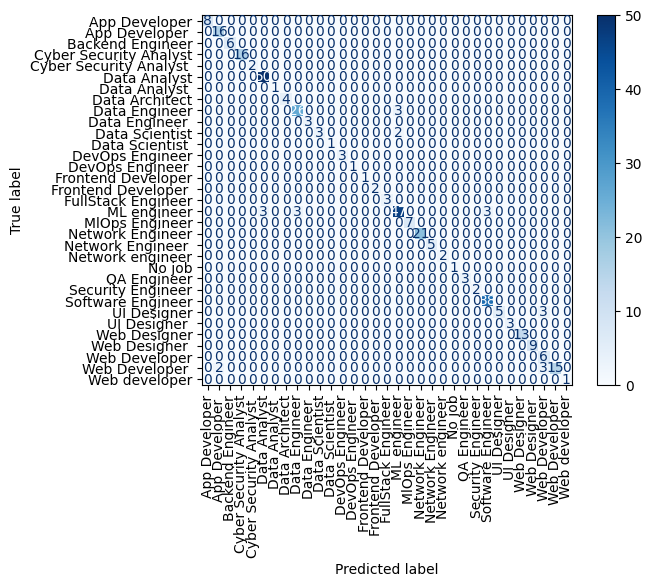

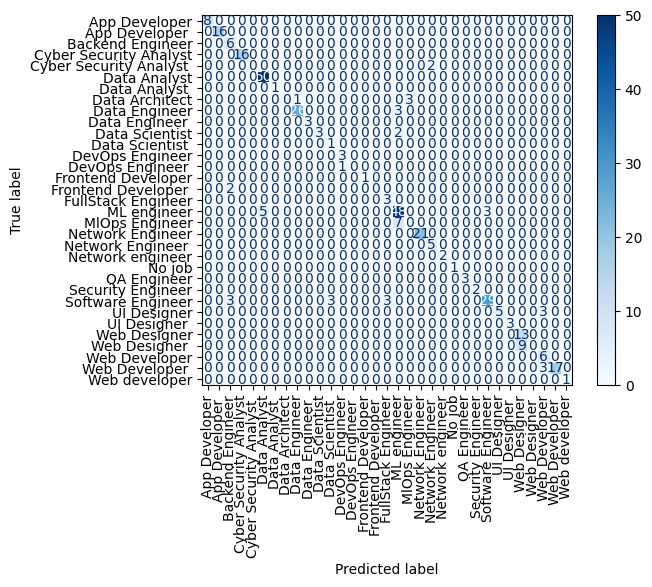

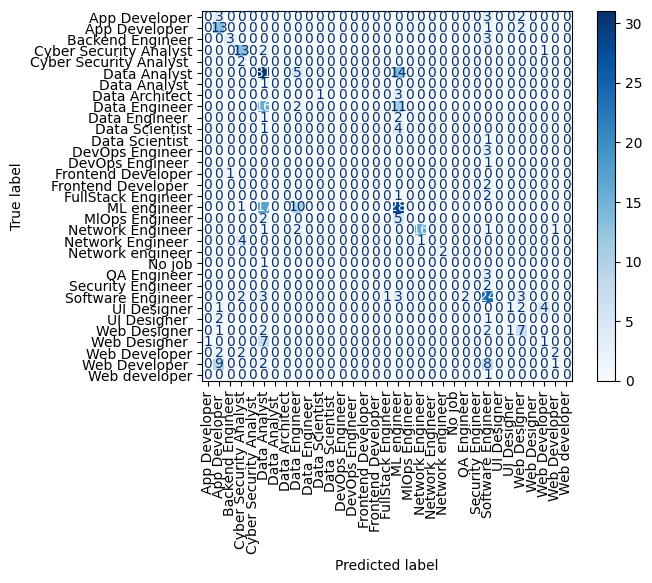

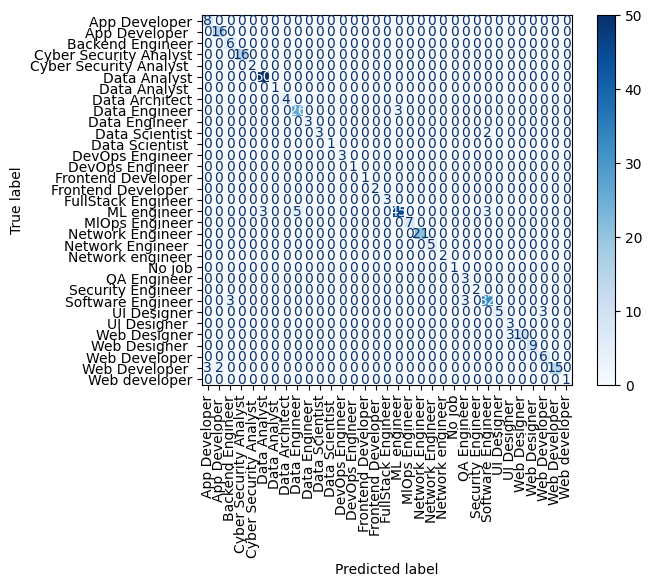

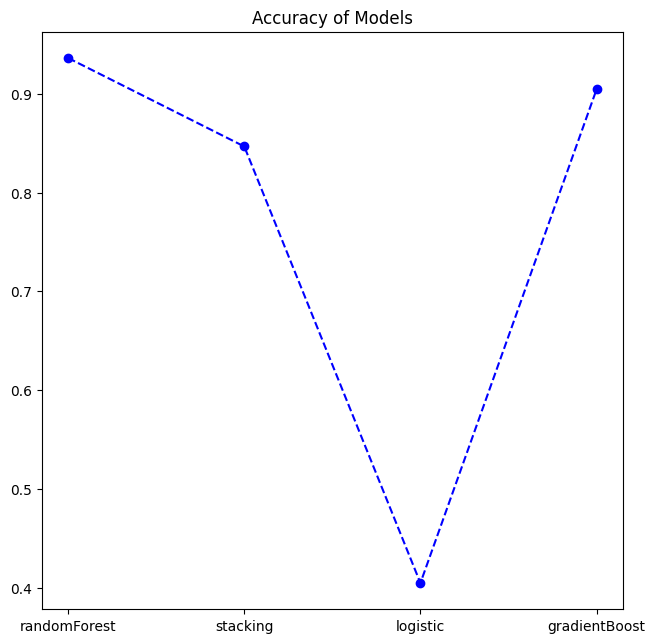

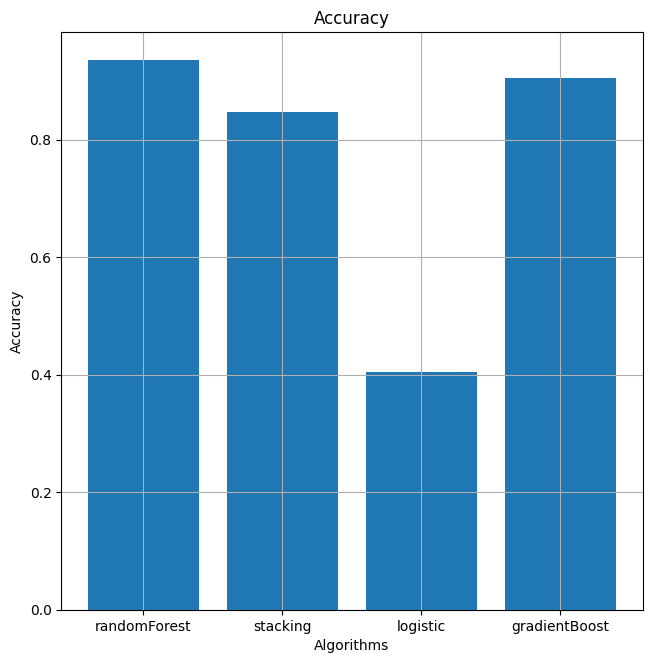

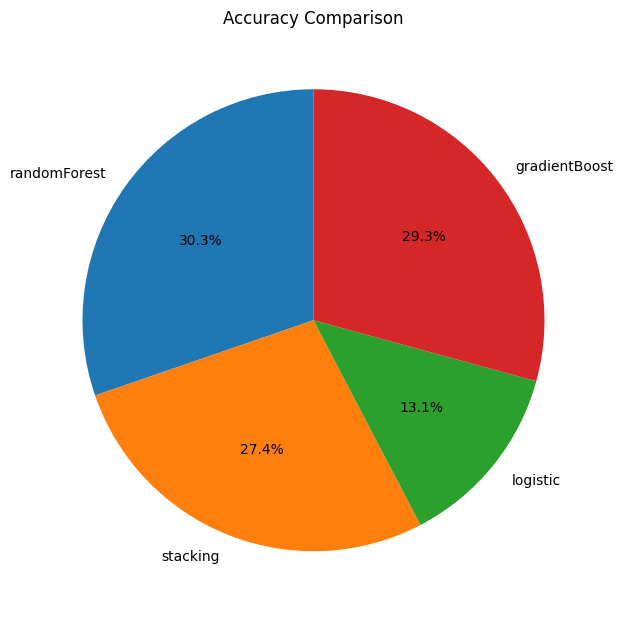

In [10]:
import time, warnings
from turtle import color, title

import sklearn
import pickle  # dump model
import matplotlib.pyplot as plt
import numpy as np


FIG_SIZE = 7.5

labels = label_encoder.fit_transform(df["JOB_ROLE"].unique())

print (labels)
def plot_confusion_matrix(y_test, y_pred, title, color, normalize=False):
    if normalize == False:
        ConfusionMatrixDisplay.from_predictions(
            y_test,
            y_pred,
            cmap=color,
            xticks_rotation="vertical",
        )

        return
    ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        cmap=color,
        normalize="true",
        xticks_rotation="vertical",
    )
    return
    # cm.plot()


models = []
models.append(("rf", rf))
models.append(("stacking", stacking))
models.append(("logistic", logistic))
models.append(("gb", gb))


models_name = [
    "randomForest",
    "stacking",
    "logistic",
    "gradientBoost",
]

model_test_accuracy = []
model_test_precision = []
model_test_recall = []
model_test_f1 = []


for x, y in models:
    train_start = time.time()
    y.fit(x_train, y_train)
    train_finished = time.time()
    pred_start = time.time()
    y_pred = y.predict(x_test)
    pred_stop = time.time()
    y_pred_proba = y.predict_proba(x_test)[:, 1]
    accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
    precision = sklearn.metrics.precision_score(y_test, y_pred, average="macro")
    recall = sklearn.metrics.recall_score(y_test, y_pred, average="macro")
    confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
    f1 = sklearn.metrics.f1_score(
        y_test, y_pred, average="macro", labels=np.unique(y_pred)
    )

    # append algorithm overall test results to list
    model_test_accuracy.append(accuracy)
    model_test_precision.append(precision)
    model_test_recall.append(recall)
    model_test_f1.append(f1)
    sklearn.metrics.multilabel_confusion_matrix(y_test, y_pred)

    # dump model
    pickle.dump(y, open("../models/" + x + ".pkl", "wb"))

    print(
        """
        Model: %s 
        Dataset size: %s
        Accuracy: %f
        Precision: %f
        Recall: %f
        F1: %f
        Train time: %s
        Predict time: %s
        """
        % (
            x,
            len(df),
            accuracy,
            precision,
            recall,
            f1,
            train_finished - train_start,
            pred_stop - pred_start,
        )
    )

    # overall plot_confusion_matrix
    plot_confusion_matrix(
        y_test,
        y_pred,
        x,
        
        plt.cm.Blues,
    )

# plot dash graph
fig, axes = plt.subplots(figsize=(FIG_SIZE, FIG_SIZE))
axes.title.set_text("Accuracy of Models")
axes.plot(
    models_name,
    model_test_accuracy,
    label="Accuracy",
    marker="o",
    color="blue",
    linestyle="dashed",
)


# plot histogram
fig, axes = plt.subplots(figsize=(FIG_SIZE, FIG_SIZE))
axes.bar(models_name, model_test_accuracy)
axes.set_title("Accuracy")
axes.set_ylabel("Accuracy")
axes.set_xlabel("Algorithms")
axes.grid(True)
plt.show()


# float a pie chart
fig, axes = plt.subplots(figsize=(FIG_SIZE, FIG_SIZE))
axes.pie(
    model_test_accuracy,
    labels=models_name,
    autopct="%1.1f%%",
    startangle=90,
)
axes.grid(True)
axes.set_title("Accuracy Comparison")
plt.show()